In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.fft as fft
import pickle
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tslearn.metrics import dtw
from scipy.signal import find_peaks
from scipy.signal import butter, filtfilt

/home/quyi/.local/lib/python3.9/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
os.getcwd()

'/home/quyi/temple_hpc_transf'

In [3]:
ppg_lst = []
acc_lst = []
for f in os.listdir(os.getcwd() + '/AI_data'):
    if f[-7:] == 'ppg.csv' and f[0] != '.':
        ppg_lst.append(f)
    if f[-9:] == 'accel.csv' and f[0] != '.':
        acc_lst.append(f)
    print(f)

yi_qu1_ppg.csv
PPG_data_processing.py
AI_vr1_gyro.csv
yi_qu2_ppg.csv
yi_qu2.dat
AI_vr1_accel.csv
AI_vr2_gyro.csv
data_preprocess_vp.py
yi_qu3_ppg.csv
AI_vr2_accel.csv
AI_vr1.txt
yi_qu1.dat
AI_vr3_gyro.csv
AI_vr3.txt
yi_qu3.dat
AI_vr2.txt
AI_vr3_accel.csv


In [4]:
df_acc = pd.read_csv('./AI_data/'+acc_lst[0])
df_ppg = pd.read_csv('./AI_data/'+ppg_lst[0])

In [6]:
print(df_acc.shape)
print(df_ppg.shape)
df_acc = df_acc.iloc[200:150000, :]
df_ppg = df_ppg.iloc[200:150000, :]
print(df_acc.shape)
print(df_ppg.shape)

(149800, 3)
(149800, 1)
(149600, 3)
(149600, 1)


In [5]:
def bandpass_smooth(data, lowcut, highcut, window_size=1000, fs=2000, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    window = np.ones(window_size) / window_size
    smoothed = np.convolve(y, window, mode='valid')
    return smoothed

In [6]:
filted_acc = bandpass_smooth(df_acc.mean(axis=1), 10, 40)
# filted_ppg = bandpass_smooth(df_ppg, 10, 40)
print(filted_acc.shape)
stander = StandardScaler()
scaler = MinMaxScaler(feature_range=(-1, 1))
PPG = scaler.fit_transform(stander.fit_transform(df_ppg.to_numpy().reshape(-1, 1))).squeeze()
ACC = scaler.fit_transform(stander.fit_transform(filted_acc.reshape(-1, 1))).squeeze()
print(PPG.shape)
print(ACC.shape)

(150263,)
(156083,)
(150263,)


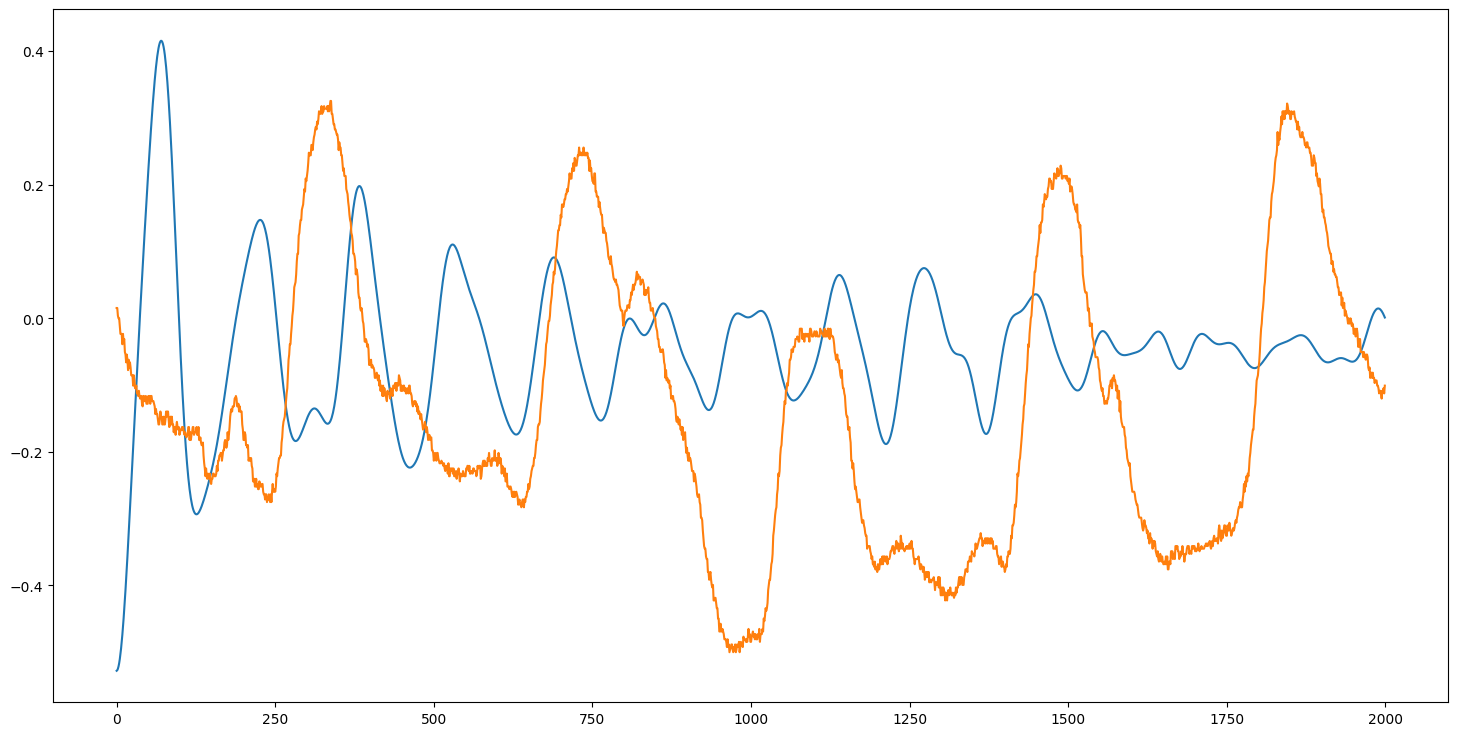

In [7]:
plt.figure(figsize=(18, 9))

# plt.plot(filted_acc[1000:140000])
plt.plot(ACC[:2000])
plt.plot(PPG[:2000])

In [8]:
class ACC2PPGDataset(Dataset):
    def __init__(self, ACC_lst, PPG_lst, window_size=160):
        super().__init__()
        self.PPG_lst = PPG_lst
        self.ACC_lst = ACC_lst
        self.window_size = window_size

    def __len__(self):
        return len(self.PPG_lst) - self.window_size + 1
    
    def __getitem__(self, idx):
        src = torch.tensor(self.ACC_lst[idx: idx+self.window_size]).float()
        # tgt = torch.fft.fft(src)
        tgt = src
        target = torch.tensor(self.PPG_lst[idx: idx+self.window_size]).float()
        return src, tgt, target

In [9]:
acc2ppg_dataset = ACC2PPGDataset(ACC[5000:145000], PPG[5000:145000])
print(len(acc2ppg_dataset))
d0src, d0tgt, target = acc2ppg_dataset[0]
print(d0src.shape, d0tgt.shape, target.shape)
print(d0src.dtype, d0tgt.dtype, target.dtype)

139841
torch.Size([160]) torch.Size([160]) torch.Size([160])
torch.float32 torch.float32 torch.float32


In [10]:
def calculate_dtw_loss(pred, target):
    dtw_loss = 0.0
    batch_size = pred.shape[0]
    for i in range(batch_size):
        pred_seq = pred[i].squeeze().detach().cpu().numpy()
        target_seq = target[i].squeeze().detach().cpu().numpy()

        distance = dtw(pred_seq, target_seq)
        dtw_loss += distance
    return torch.tensor(dtw_loss / batch_size, requires_grad=True)

def combined_loss(pred, target, alpha=0.5):
    mse_loss = nn.MSELoss()(pred, target)
    dtw_loss = calculate_dtw_loss(pred, target)
    return alpha * mse_loss + (1 - alpha) * dtw_loss

In [11]:
class SelfAttention1D(nn.Module):
    def __init__(self, channels):
        super(SelfAttention1D, self).__init__()
        # Query, Key, and Value projections
        self.query = nn.Conv1d(channels, channels // 8, kernel_size=1)
        self.key = nn.Conv1d(channels, channels // 8, kernel_size=1)
        self.value = nn.Conv1d(channels, channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))  # Learnable scaling factor for attention output

    def forward(self, x):
        batch_size, channels, seq_length = x.size()
        
        # Generate Query, Key, and Value
        query = self.query(x).permute(0, 2, 1)  # [batch_size, seq_length, channels // 8]
        key = self.key(x)  # [batch_size, channels // 8, seq_length]
        value = self.value(x)  # [batch_size, channels, seq_length]

        # Compute attention scores
        attention = torch.bmm(query, key)  # [batch_size, seq_length, seq_length]
        attention = torch.softmax(attention, dim=-1)  # Normalize attention scores

        # Apply attention to Value
        attention_output = torch.bmm(value, attention)  # [batch_size, channels, seq_length]

        # Scale and combine with the input
        return self.gamma * attention_output + x

In [12]:
class GAN_Generator(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down1 = nn.Conv1d(1, 128, 4, 2, padding_mode='replicate')
        self.down2 = nn.Conv1d(128, 256, 4, 2, padding_mode='replicate')
        self.down3 = nn.Conv1d(256, 512, 4, 2, padding_mode='replicate')
        self.down4 = nn.Conv1d(512, 512, 4, 2, padding_mode='replicate')
        self.d_att1 = SelfAttention1D(128)
        self.d_att2 = SelfAttention1D(256)
        self.d_att3 = SelfAttention1D(512)
        self.d_att4 = SelfAttention1D(512)
        self.act1 = nn.ReLU()
        self.up1 = nn.ConvTranspose1d(512, 512, 4, 2, output_padding=0)
        self.up2 = nn.ConvTranspose1d(1024, 256, 4, 2, output_padding=0)
        self.up3 = nn.ConvTranspose1d(512, 128, 4, 2, output_padding=1)
        self.u_att1 = SelfAttention1D(512)
        self.u_att2 = SelfAttention1D(256)
        self.u_att3 = SelfAttention1D(128)
        self.up_sample = nn.Upsample(scale_factor=2)
        self.padding = nn.ConstantPad1d((1, 1), 0)
        self.outp = nn.Conv1d(256, out_channels, 5, padding=2, padding_mode='replicate')
        self.act2 = nn.Tanh()

    def forward(self, x):
        d1 = self.down1(x)
        d1 = self.d_att1(d1)
        d1 = self.act1(d1)
        d2 = self.down2(d1)
        d2 = self.d_att2(d2)
        d2 = self.act1(d2)
        d3 = self.down3(d2)
        d3 = self.d_att3(d3)
        d3 = self.act1(d3)
        d4 = self.down4(d3)
        d4 = self.d_att4(d4)
        d4 = self.act1(d4)

        u1 = self.up1(d4)
        u1 = self.u_att1(u1)
        u1 = torch.cat((u1, d3), 1)
        u2 = self.up2(u1)
        u2 = self.u_att2(u2)
        u2 = torch.cat((u2, d2), 1)
        u3 = self.up3(u2)
        u3 = self.u_att3(u3)
        u3 = torch.cat((u3, d1), 1)
        out = self.up_sample(u3)
        out = self.padding(out)
        out = self.outp(out)
        out = self.act2(out)
        return out

In [13]:
class GAN_Discriminator(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels * 2, 128, 6, 3, padding_mode='replicate')
        self.att1 = SelfAttention1D(128)
        self.conv2 = nn.Conv1d(128, 256, 6, 3, padding_mode='replicate')
        self.att2 = SelfAttention1D(256)
        self.conv3 = nn.Conv1d(256, 512, 6, 3, padding_mode='replicate')
        self.att3 = SelfAttention1D(512)
        self.conv4 = nn.Conv1d(512, out_channels, 4, padding_mode='replicate')
        self.act = nn.LeakyReLU(0.2)
        self.outp = nn.Sigmoid()
        # self.outp = nn.Tanh()

    def forward(self, d1, d2):
        x = torch.cat((d1, d2), 1)
        x = self.conv1(x)
        x = self.att1(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.att2(x)
        x = self.act(x)
        x = self.conv3(x)
        x = self.att3(x)
        x = self.act(x)
        x = self.conv4(x)
        x = self.outp(x)
        x = x.squeeze(1)
        return x

In [14]:
def calculate_wa_loss(discriminator, real_ecg, fake_ecg, real_ppg):
    alpha = torch.rand((real_ecg.shape[0], 1, 1)).to(device)
    interpolates = (alpha * real_ecg + ((1 - alpha) * fake_ecg)).requires_grad_(True)
    d_interp = discriminator(interpolates, real_ppg)
    d_interp = d_interp.unsqueeze(1)
    fake = torch.full((real_ecg.shape[0], 1, 1), 1, dtype=torch.float32, device=device)

    grad = torch.autograd.grad(outputs=d_interp, inputs=interpolates, grad_outputs=fake, create_graph=True, retain_graph=True, only_inputs=True)[0]
    grad = grad.view(grad.shape[0], -1)
    grad_penalty = ((grad.norm(2, dim=1) - 1) ** 2).mean()
    return grad_penalty

In [15]:
def detect_peaks(signal, height=None, distance=None):
    peaks, _ = find_peaks(signal, height=height, distance=distance)
    return peaks

def align_peaks(pred_peaks, target_peaks):
    aligned_pred = []
    aligned_target = []
    
    for target in target_peaks:
        # Find the nearest peak in predicted peaks
        distances = torch.abs(pred_peaks - target)
        nearest_idx = torch.argmin(distances)
        aligned_pred.append(pred_peaks[nearest_idx])
        aligned_target.append(target)

    return torch.stack(aligned_pred), torch.stack(aligned_target)

def peak_alignment_loss(pred, target, height=None, distance=None):
    loss = 0
    batch_size = pred.shape[0]
    for i in range(batch_size):
        # Convert signals to NumPy arrays for peak detection
        pred_np = pred[i, 0].detach().cpu().numpy()
        target_np = target[i, 0].detach().cpu().numpy()

        # Detect peaks
        pred_peaks = detect_peaks(pred_np, height=height, distance=distance)
        target_peaks = detect_peaks(target_np, height=height, distance=distance)
        # print(pred_peaks.shape)
        # print(target_peaks.shape)

        # Compute L2 distance between matched peaks
        if len(pred_peaks) > 0 and len(target_peaks) > 0:
            pred_peaks_tensor = torch.tensor(pred_peaks, device=pred.device).to(torch.float32)
            target_peaks_tensor = torch.tensor(target_peaks, device=pred.device).to(torch.float32)
            aligned_pred, aligned_target = align_peaks(pred_peaks_tensor, target_peaks_tensor)
            loss += torch.mean((aligned_pred - aligned_target) ** 2)

    return loss / batch_size

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:15<00:00,  3.30it/s]


Epoch 0, d_loss: 1.3860737085342407, g_loss: 1.7804911136627197


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:13<00:00,  3.36it/s]


Epoch 1, d_loss: 1.3862965106964111, g_loss: 1.778733491897583


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:13<00:00,  3.36it/s]


Epoch 2, d_loss: 1.3862948417663574, g_loss: 1.8034671545028687


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:14<00:00,  3.35it/s]


Epoch 3, d_loss: 1.3862943649291992, g_loss: 1.8346912860870361


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:13<00:00,  3.37it/s]


Epoch 4, d_loss: 1.3862943649291992, g_loss: 1.8595716953277588


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:13<00:00,  3.36it/s]


Epoch 5, d_loss: 1.3862943649291992, g_loss: 1.8660030364990234


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:13<00:00,  3.37it/s]


Epoch 6, d_loss: 1.3862942457199097, g_loss: 1.8594367504119873


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:13<00:00,  3.36it/s]


Epoch 7, d_loss: 1.3862942457199097, g_loss: 1.8484342098236084


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:13<00:00,  3.35it/s]


Epoch 8, d_loss: 1.3862942457199097, g_loss: 1.839181900024414


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:13<00:00,  3.37it/s]


Epoch 9, d_loss: 1.3862942457199097, g_loss: 1.834068775177002


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:13<00:00,  3.37it/s]


Epoch 10, d_loss: 1.3862942457199097, g_loss: 1.8323466777801514


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:13<00:00,  3.37it/s]


Epoch 11, d_loss: 1.3862942457199097, g_loss: 1.8322725296020508


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:13<00:00,  3.35it/s]


Epoch 12, d_loss: 1.3862942457199097, g_loss: 1.8327932357788086


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:13<00:00,  3.36it/s]


Epoch 13, d_loss: 1.3862942457199097, g_loss: 1.8335180282592773


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:13<00:00,  3.37it/s]


Epoch 14, d_loss: 1.3862942457199097, g_loss: 1.8343288898468018


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:13<00:00,  3.36it/s]


Epoch 15, d_loss: 1.3862942457199097, g_loss: 1.8351831436157227


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:13<00:00,  3.37it/s]


Epoch 16, d_loss: 1.3862942457199097, g_loss: 1.8360528945922852


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:13<00:00,  3.37it/s]


Epoch 17, d_loss: 1.3862942457199097, g_loss: 1.836911916732788


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:13<00:00,  3.38it/s]


Epoch 18, d_loss: 1.3862942457199097, g_loss: 1.8377363681793213


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:13<00:00,  3.37it/s]


Epoch 19, d_loss: 1.3862942457199097, g_loss: 1.8385050296783447


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9840/9840 [05:02<00:00, 32.48it/s]


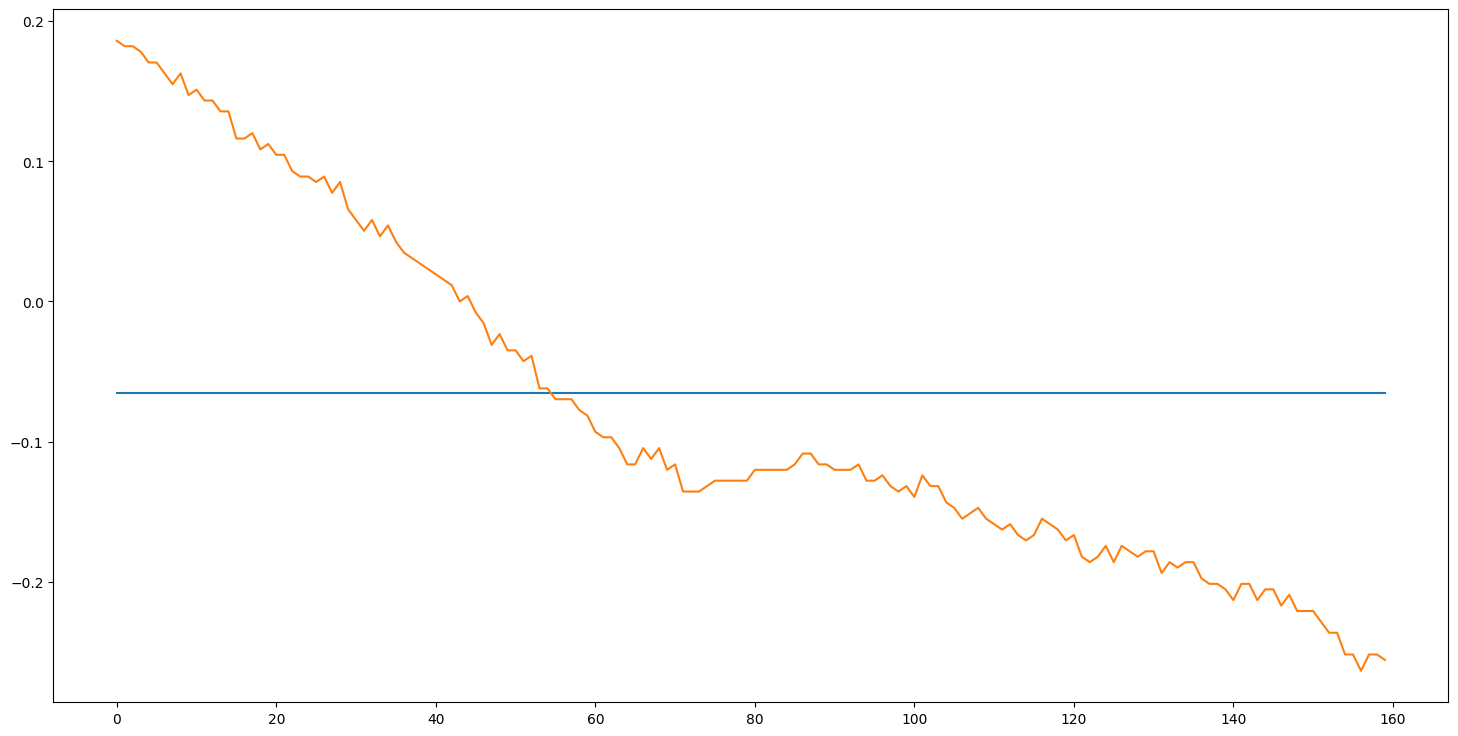

In [27]:
num_epochs = 20

window_size = 160

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

generator = GAN_Generator().to(device)
discriminator = GAN_Discriminator().to(device)
generator = generator.to(torch.float32).to(device)
discriminator = discriminator.to(torch.float32).to(device)
dataset = ACC2PPGDataset(ACC[3000:130000], PPG[3000:130000])
dataloader = DataLoader(dataset, batch_size=512)


# criterion = nn.MSELoss()
adversarial_loss = nn.BCELoss()
# lr = 10e-2
optimizer_G = optim.Adam(generator.parameters(), weight_decay=0.1)
optimizer_D = optim.Adam(discriminator.parameters(), weight_decay=0.1)

# schedular_G = optim.lr_schedular.StepLR(optimizer_G, step_size=10, gamma=0.1)
# schedular_D = optim.lr_schedular.StepLR(optimizer_D, step_size=10, gamma=0.1)

train_log = []

generator.train()
discriminator.train()
for epoch in range(num_epochs):
    # running_loss = 0
    for real_ppg, tgt, real_ecg in tqdm(dataloader):
        real_ppg = real_ppg.unsqueeze(1).to(device)
        real_ecg = real_ecg.unsqueeze(1).to(device)

        batch_size = real_ppg.shape[0]
        # print(batch_size)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train discriminator real
        optimizer_D.zero_grad()
        pred_real = discriminator(real_ecg, real_ppg)
        d_loss_real = adversarial_loss(pred_real, real_labels)
        # d_loss_real.backward()

        # Train discriminator fake
        fake_ecg = generator(real_ppg)
        pred_fake = discriminator(fake_ecg, real_ppg)
        d_loss_fake = adversarial_loss(pred_fake, fake_labels)
        # d_loss_fake.backward()

        d_loss = (d_loss_real + d_loss_fake) * 1 ## Update!!
        # d_loss += calculate_wa_loss(discriminator, real_ecg, fake_ecg, real_ppg)
        d_loss.backward()
        optimizer_D.step()
        
        # Train generator
        optimizer_G.zero_grad()
        fake_ecg = generator(real_ppg)
        pred_fake = discriminator(fake_ecg, real_ppg)
        g_loss = adversarial_loss(pred_fake, real_labels)
        # peak_loss = get_peak_loss(fake_ecg, real_ecg)
        peak_loss = peak_alignment_loss(fake_ecg, real_ecg, height=0.3, distance=10)
        g_loss += combined_loss(fake_ecg, real_ecg)
        g_loss += peak_loss
        
        
        g_loss.backward()

        optimizer_G.step()

    # schedular_D.step()
    # schedular_G.step()
    print(f"Epoch {epoch}, d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")
    train_log.append([d_loss.item(), g_loss.item()])

    with open(f"acc_ppg_train_loss_gan_att_peakalign_04_160_epoch{epoch}.pkl", "wb") as f:
        pickle.dump(train_log, f)
    torch.save(generator.state_dict(), f"acc_ppg_gan_generator_att_peakalign_04_160.pth")
    torch.save(discriminator.state_dict(), f"acc_ppg_gan_discriminator_att_peakalign_04_160.pth")

# Test 
test_dataset = ACC2PPGDataset(ACC[130001:140000], PPG[130001:140000])
test_dataloader = DataLoader(test_dataset, batch_size=1)
# generator = GAN_Generator()
# generator = generator.to(torch.float32)
# generator.load_state_dict(torch.load("gan_generator_bceloss.pth", weights_only=True))
# criterion = nn.MSELoss()

test_log = []
out_lst = []
target_lst = []
device = "cpu"
generator.to(device)

for src, tgt, target in tqdm(test_dataloader):
    src = src.unsqueeze(1).to(device)
    # tgt = tgt.to(device)
    target = target.unsqueeze(1)
    target = target.to(device)
    out = generator(src)
    out = out.to(device)
    out_lst.append(out)
    target_lst.append(target)
    # loss = criterion(out, target)
    loss = combined_loss(out, target)
    test_log.append(loss.item())


out_lst_cpu = np.array([o.detach().to("cpu") for o in out_lst]).squeeze()
target_lst_cpu = np.array([t.detach().to("cpu") for t in target_lst]).squeeze()
# print(out_lst_cpu.shape)
# print(target_lst_cpu.shape)
plt.figure(figsize=(18, 9))

plt.plot(out_lst_cpu[0])
plt.plot(target_lst_cpu[0])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9840/9840 [02:06<00:00, 78.04it/s]


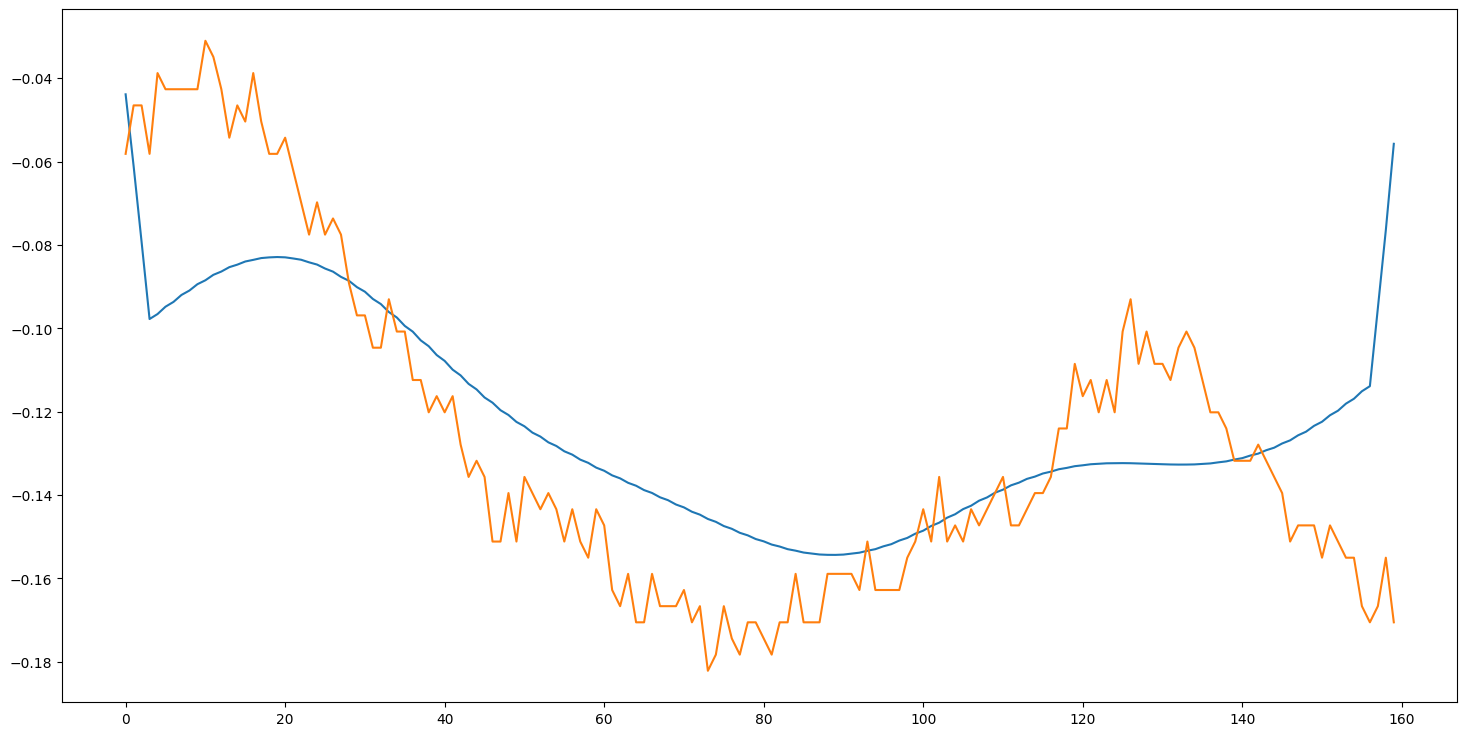

In [107]:
# Test 
test_dataset = ACC2PPGDataset(ACC[140001:150000], PPG[140001:150000])
test_dataloader = DataLoader(test_dataset, batch_size=1)
generator = GAN_Generator()
generator = generator.to(torch.float32)
generator.load_state_dict(torch.load("acc_ppg_gan_generator_att_peakalign_03_10.pth", weights_only=True))
criterion = nn.MSELoss()

test_log = []
out_lst = []
target_lst = []
device = "cpu"
generator.to(device)

for src, tgt, target in tqdm(test_dataloader):
    src = src.unsqueeze(1).to(device)
    # tgt = tgt.to(device)
    target = target.unsqueeze(1)
    target = target.to(device)
    out = generator(src)
    out = out.to(device)
    out_lst.append(out)
    target_lst.append(target)
    # loss = criterion(out, target)
    loss = combined_loss(out, target)
    test_log.append(loss.item())


out_lst_cpu = np.array([o.detach().to("cpu") for o in out_lst]).squeeze()
target_lst_cpu = np.array([t.detach().to("cpu") for t in target_lst]).squeeze()
# print(out_lst_cpu.shape)
# print(target_lst_cpu.shape)
plt.figure(figsize=(18, 9))

plt.plot(out_lst_cpu[0])
plt.plot(target_lst_cpu[0])

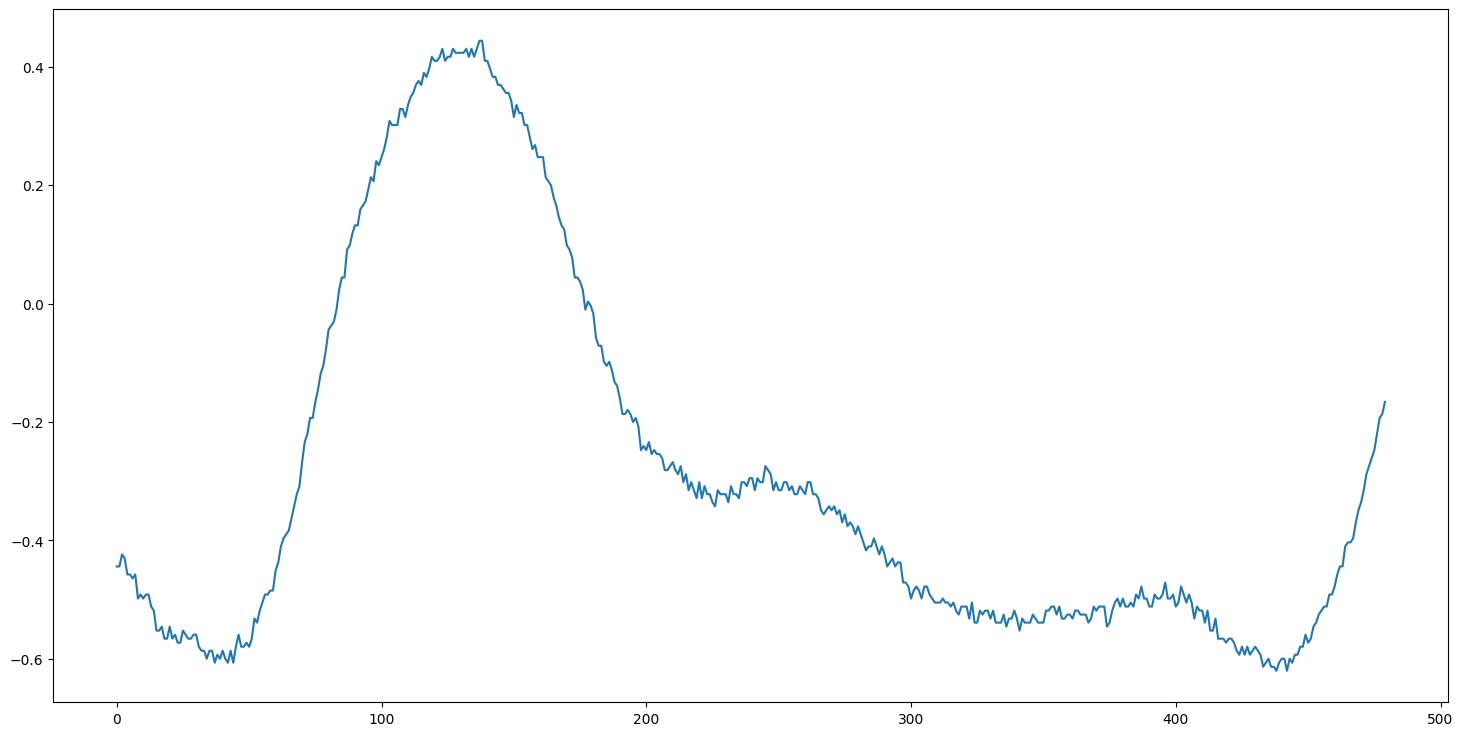

In [144]:
plt.figure(figsize=(18, 9))

plt.plot(PPG[:480])